# 线性分类器——Fisher线性判别准则

基本要求：

- 同时采用身高和体重数据作为特征，用Fisher 线性判别方法求分类器，将该分类器应用到训练和测试样本，考察训练和测试错误情况。

- 将训练样本和求得的决策边界画到图上，同时把以往用Bayes 方法求得的分类器也画到图上，比较结果的异同。

- 选择上述实验的Fisher 线性判别方法，用留一法在训练集上估计错误率，与在测试集上得到的错误率进行比较。


In [1]:
# 导入基本库
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

## 数据预处理

In [2]:
colume_names = ['','gender','height','weight','size']
df= pd.read_excel('data/gender.xlsx',index_col=0,names=colume_names)
df.head(5)

,gender,height,weight,size
,,,,
1,女,163.0,62.0,36.0
2,女,158.0,42.0,36.0
3,男,168.0,67.0,42.0
4,男,180.0,67.0,41.0
5,男,180.0,75.0,46.0


In [3]:
df.shape

(571, 4)

这里可以看到数据有4个维度，分别为性别、身高、体重、鞋码，共有571条记录。下面做一些简单的处理：

In [4]:
# 性别数据转换
df.replace('男',1,inplace=True)
df.replace('女',2,inplace=True)
df.head(5)

,gender,height,weight,size
,,,,
1,2,163.0,62.0,36.0
2,2,158.0,42.0,36.0
3,1,168.0,67.0,42.0
4,1,180.0,67.0,41.0
5,1,180.0,75.0,46.0


## Fisher 线性判别分类器设计

### 数据分布可视化

In [5]:
# 数据提取
data = df[['height','weight','gender']].copy()
data.columns = ['feature1', 'feature2', 'category']
data.head(5)

,feature1,feature2,category
,,,
1,163.0,62.0,2
2,158.0,42.0,2
3,168.0,67.0,1
4,180.0,67.0,1
5,180.0,75.0,1


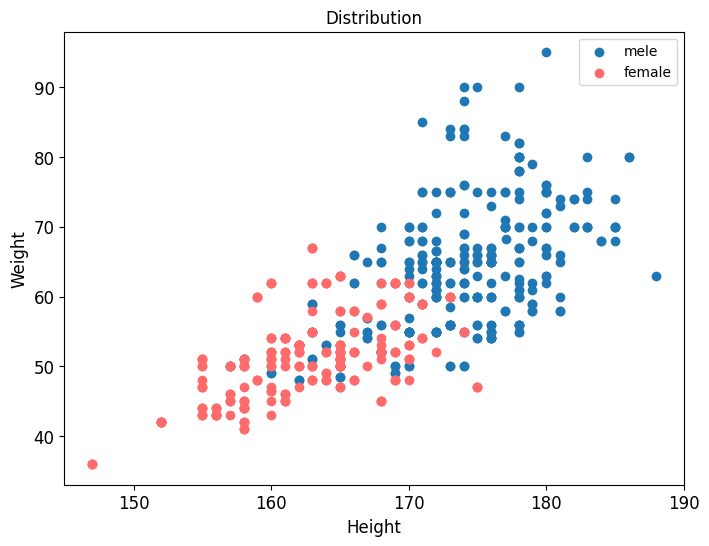

In [6]:
cate1_df = data.loc[data['category']==1]
cate2_df = data.loc[data['category']==2]
# 二元高斯概率分布图水平面投影
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(cate1_df.feature1, cate1_df.feature2)
plt.scatter(cate2_df.feature1, cate2_df.feature2,color='#ff6b6b')
plt.xlabel('Height',fontsize=12)
plt.ylabel('Weight',fontsize=12) 
plt.title('Distribution',fontsize=12)
plt.legend(["mele","female"])
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

### Fisher准则函数步骤

- 计算$M_1$和$M_2$(样本均值)

- 计算$S_1和S_2$(样本类内离散矩阵)  $S_i=\sum(x_k-M_i)(x_k-M_i)^T$

- 计算$S_w=S_1+S_2$

- 计算$S_w^{-1}(n>d,S_w可逆)$

- 计算$w^*=S_w^{-1}(M_1-M_2)$

- 计算$m_i=w^{*T}M_i(i=1,2)和w_0$,整理决策规则表达式或采用Bayes决策

In [7]:
# 计算各类样本均值
M1 = cate1_df.mean().values[0:2]
M2 = cate2_df.mean().values[0:2]

In [8]:
# 计算 𝑆1和𝑆2 (样本类内离散矩阵)

S1 = np.matrix(np.zeros((2,2)))
for x in cate1_df.values:
    S = np.matrix(x[0:2]-M1).T @ np.matrix(x[0:2]-M1)
    S1 = S1+S
S2 = np.matrix(np.zeros((2,2)))
for x in cate2_df.values:
    S = np.matrix(x[0:2]-M2).T @ np.matrix(x[0:2]-M2)
    S2 = S2+S

In [9]:
# 计算投影权重矩阵 W_

S_w = S1+S2

S_w_inv = np.linalg.inv(S_w)

w_ = S_w_inv @ (M1-M2)

# 计算投影后样本的均值

m1 = w_ @ M1
m2 = w_ @ M2

w_[(0,0)]

0.0005705953998755753

In [10]:
# 利用先验知识选择分界阈值点W0:
w0 = (m1+m2)/2
w0

matrix([[0.10564548]])

In [11]:
def g_x(x):
    # 投影并与分解值比较
    y = w_ @ x - w0
    if(y > 0):
        print("1")
    else:
        print("2")

In [12]:
# 简单测试
g_x(np.matrix([170,50]).T)

2


### 分界面可视化

In [13]:
# 根据比例确定先验概率:
num = list(data['category'].value_counts())
male_num = num[0]
female_num = num[1]
p_w1 = male_num /(num[0]+num[1])
p_w2 = female_num / (num[0]+num[1])

# 估计概率分布 (计算样本期望 μ 和 协方差 cov)

u1_1 = cate1_df.feature1.mean()
u1_2 = cate1_df.feature2.mean()
u1 = np.array([u1_1, u1_2])
u2_1 = cate2_df.feature1.mean()
u2_2 = cate2_df.feature2.mean()
u2 = np.array([u2_1, u2_2])

# 协方差矩阵
cov1_1 = cate1_df.feature1.cov(cate1_df.feature1)
cov1_2 = cate1_df.feature1.cov(cate1_df.feature2)
cov1_3 = cate1_df.feature2.cov(cate1_df.feature1)
cov1_4 = cate1_df.feature2.cov(cate1_df.feature2)
cov1 = np.array([[cov1_1, cov1_2], [cov1_3, cov1_4]])

cov2_1 = cate2_df.feature1.cov(cate2_df.feature1)
cov2_2 = cate2_df.feature1.cov(cate2_df.feature2)
cov2_3 = cate2_df.feature2.cov(cate2_df.feature1)
cov2_4 = cate2_df.feature2.cov(cate2_df.feature2)
cov2 = np.array([[cov2_1, cov2_2], [cov2_3, cov2_4]])
print(cov1,'\n',cov2)

[[29.40047665 24.98623789]
 [24.98623789 82.17291372]] 
 [[27.27968537 17.43315967]
 [17.43315967 35.26327925]]


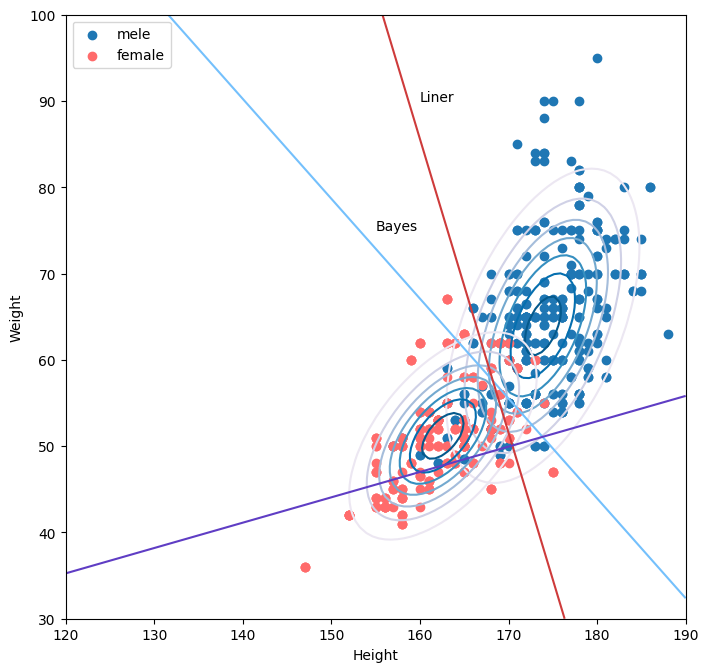

In [14]:
# 可视化类概率分布
from scipy import stats

x = np.linspace(120, 190, 100)
y = np.linspace(30, 100, 100)
x, y = np.meshgrid(x, y)
pos = np.dstack((x, y))

z1 = stats.multivariate_normal.pdf(pos, mean=u1, cov=cov1)
z2 = stats.multivariate_normal.pdf(pos, mean=u2, cov=cov2)

# 绘制分界线
# 1:不相互独立
# def dependent(x,y):
#     v1 = np.linalg.inv(cov1)
#     v2 = np.linalg.inv(cov2)
#     g1 = -0.5*(((x-u1_1)*v1[0][0]+(y-u1_2)*v1[1][0])*(x-u1_1) +
#                ((x-u1_1)*v1[0][1]+(y-u1_2)*v1[1][1])*(y-u1_2))
#     -0.5*np.log(abs(cov1))+np.log(p_w1)
#     g2 = -0.5*(((x-u2_1)*v2[0][0]+(y-u2_2)*v2[1][0])*(x-u2_1) +
#                ((x-u2_1)*v2[0][1]+(y-u2_2)*v2[1][1])*(y-u2_2))
#     -0.5*np.log(abs(cov2))+np.log(p_w2)
#     return g1-g2
# z3 = dependent(x,y)

# 2：相互独立
def independent(x,y):
    v1 = np.linalg.inv(cov2)
    v2 = np.linalg.inv(cov2)
    g1 = -0.5*(((x-u1_1)*v1[0][0]+(y-u1_2)*v1[1][0])*(x-u1_1) +
               ((x-u1_1)*v1[0][1]+(y-u1_2)*v1[1][1])*(y-u1_2))
    -0.5*np.log(abs(cov1))+np.log(p_w1)
    g2 = -0.5*(((x-u2_1)*v2[0][0]+(y-u2_2)*v2[1][0])*(x-u2_1) +
               ((x-u2_1)*v2[0][1]+(y-u2_2)*v2[1][1])*(y-u2_2))
    -0.5*np.log(abs(cov2))+np.log(p_w2)
    return g1-g2
z4 = independent(x,y)

# 3：线性分类器分界面
def Linear(x,y):
    return w_[(0,0)]*x+w_[(0,1)]*y- w0
z5 = Linear(x,y)
# 4: 投影
z6 = w_[(0,1)]*x-w_[(0,0)]*y

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(cate1_df.feature1, cate1_df.feature2)
plt.scatter(cate2_df.feature1, cate2_df.feature2, color='#ff6b6b')


plt.contour(x, y, z1, cmap='PuBu')
plt.contour(x, y, z2, cmap='PuBu')
# plt.contour(x, y, z3,[0])
plt.contour(x, y, z4,colors=['#74c0fc'],levels=[0])
plt.contour(x, y, z5,colors=['#ce3b3b'],levels=[0])
plt.contour(x, y, z6,colors=['#5f3dc4'],levels=[0])

plt.xlabel('Height')
plt.ylabel('Weight')

plt.text(160,90,"Liner")
plt.text(155,75,"Bayes")
plt.legend(["mele","female"])
plt.show()

### 封装测试

In [15]:
# Fisher准则分类器
class FisherLiner():
    def __init__(self):
        self.pro = []
        self.w_ = []
        self.w0 = []

    # 训练

    def fit(self, x_train, y_train):

        cate_df = pd.concat([x_train, y_train], axis=1)
        cate_df.columns = ['feature1', 'feature2', 'category']
        cate1_df = cate_df.loc[cate_df['category'] == 1]
        cate2_df = cate_df.loc[cate_df['category'] == 2]

        # 计算各类样本均值
        M1 = cate1_df.mean().values[0:2]
        M2 = cate2_df.mean().values[0:2]

        # 计算 𝑆1和𝑆2 (样本类内离散矩阵)
        S1 = np.matrix(np.zeros((2, 2)))
        for x in cate1_df.values:
            S = np.matrix(x[0:2]-M1).T @ np.matrix(x[0:2]-M1)
            S1 = S1+S
        S2 = np.matrix(np.zeros((2, 2)))
        for x in cate2_df.values:
            S = np.matrix(x[0:2]-M2).T @ np.matrix(x[0:2]-M2)
            S2 = S2+S

        # 计算投影权重矩阵 W_
        S_w = S1+S2
        S_w_inv = np.linalg.inv(S_w)
        self.w_ = S_w_inv @ (M1-M2)
        # 计算投影后样本的均值
        m1 = w_ @ M1
        m2 = w_ @ M2
        
        self.w0 = (m1+m2)/2
        # 利用先验知识选择分界阈值点W0:
#         num = list(cate_df['category'].value_counts())
#         male_num = num[0]
#         female_num = num[1]
#         self.w0 = (male_num*m1+female_num*m2)/(male_num+female_num)  # 根据比例确定

        
    def predict(self, x_test):
        x_test = x_test.values
        y_predict = []
        # 判别
        for i in range(len(x_test)):
            x = x_test[i][0]
            y = x_test[i][1]
        # 投影并与分界值比较
#             result = self.w_ @ np.matrix(x).T - self.w0
            result = self.w_[(0,0)]*x+self.w_[(0,1)]*y- self.w0
            if result > 0:
                y_predict.append(1)
            else:
                y_predict.append(2)
        return y_predict

In [16]:
X = data.iloc[:,0:2] # 特征
Y = data.iloc[:,2] # 标签

In [17]:
from sklearn.metrics import accuracy_score
from sklearn import tree

accuracies_test = []
accuracies_train = []

# 确定分割比例(前提：样本是随机均匀分布的)
proportion = 98/100
split_index = int(df.shape[0]*proportion)  # 分割点

x_train, x_test = X.iloc[range(0,split_index)], X.iloc[range(split_index,df.shape[0])]
y_train, y_test = Y.iloc[range(0,split_index)], Y.iloc[range(split_index,df.shape[0])]

model = FisherLiner()  # 模型原型 选择
#     model = tree.DecisionTreeClassifier()  # 模型原型 选择

model.fit(x_train.copy(), y_train.copy())  # 训练

# 1:预测训练样本
y_predict_train = model.predict(x_train)  # 预测

accuracy = accuracy_score(y_pred=y_predict_train, y_true=y_train)
accuracies_train.append(accuracy)

print('x_train:', np.mean(accuracies_train))

# 2：预测测试样本
y_predict_test = model.predict(x_test)  # 预测
accuracy = accuracy_score(y_pred=y_predict_test, y_true=y_test)
accuracies_test.append(accuracy)

print('x_test:', np.mean(accuracies_test))

x_train: 0.8389982110912343
x_test: 0.9166666666666666


### 留一法估计错误率

留一法（Leave-One-Out，简称LOO），顾名思义，就是使k等于数据集中数据的个数，每次只使用一个作为测试集，剩下的全部作为训练集，这种方法得出的结果与训练整个测试集的期望值最为接近，但是成本过于庞大。

In [18]:
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(1,df.shape[0]):

    x_train, x_test = X.drop([i]), X.iloc[[i]]
    y_train, y_test = Y.drop([i]), Y.iloc[[i]]

    model = FisherLiner()  # 模型原型 选择
    model.fit(x_train.copy(), y_train.copy())  # 训练

    # 预测测试样本
    y_predict_test = model.predict(x_test)  # 预测
    accuracy = accuracy_score(y_pred=y_predict_test, y_true=y_test)
    accuracies.append(accuracy)

print('x_test:', np.mean(accuracies_test))

x_test: 0.9166666666666666
